In [285]:
import strawberryfields as sf
import numpy as np
from strawberryfields.utils import random_interferometer as ri 
from numpy import random
from strawberryfields.ops import *
from strawberryfields.apps import sample
import networkx as nx
import pylab as pl

In [287]:
#define a graph with n vertices and a clique of size K
def graph_gen(n,K,clique):
    """
    Args: n -- total number of vertices
          K -- size of the clique
          clique -- 1*n list, indexes of vertices in the clique
    Return: A -- adjacent matrix
            target --- 1*n array, a specific sample result corresponding to finding the maximun clique
    """
    target=np.zeros(n)
    En=np.zeros((n,n))
    for i in range(n):
        for j in range(i,n):
            En[i,j]=random.randint(0,2)
            En[j,i]=En[i,j]
    for i in range(len(clique)):
        for j in range(len(clique)):
            En[clique[i],clique[j]]=1
    for i in range(n):
        En[i,i]=0
    for i in clique:
        target[i]=1
    Graph=[]
    Graph.append(En)
    Graph.append(target)
    return Graph

In [288]:
# define the gradient of cost function

def gC(H,S):
# Args : H -- Hamiltonian ; S --T*n array of samples
    nk=np.average(S,axis=0)
    grad=np.zeros(n)
    for i in range(S.shape[0]):
        for j in range(S.shape[1]):
            element=H[i]*(S[i,j]-nk[j])*F[j]
            grad=grad+element
    grad=-1*grad/S.shape[0]
    return grad

In [289]:
#define Hamiltonian:K--subgraph size ; A--adjacent matrix ; x--samples from gbs 

def Ham(K,A,x):
    cv=2*K
    ce=1
    sum_v=np.sum(x)
    Hv=(K-sum_v)**2
    xt=np.transpose(x)
    #calculate the number of edges included in the subgrapgh
    sum_e=np.dot(xt,np.dot(A,x))
    He=K*(K-1)/2-sum_e/2
    H=cv*Hv+ce*He
    return H

In [290]:
def Fidelity(S,target):
    S=np.array(S)
    target=np.array(target)
    num=S.shape[0]
    num_t=0
    for i in range(S.shape[0]):
        Si= S[i,:]
        if (Si == target).all():
            num_t=num_t+1
    return(num_t/num)

In [294]:
#perform the iteration
def iteration(ni,T,eta,K,theta0,Graph):

#Args: ni -- iteration times 
#      T -- number of samples
#      eta -- evolution speed
#      K -- clique size
#      theta0 -- initial parameters
#      Graph -- graph from the graph generator


    A=Graph[0]
    target=Graph[1]
    #initialize the weights
    w=np.zeros(n)
    theta=theta0
    for i in range(n):
        Fi=np.transpose(F[i])
        w[i]=np.exp(-1*np.dot(theta,Fi))
    W=np.diag(w)
    #print(W)
    Aw=np.dot(W,np.dot(A,W))
    print(Aw)
    Fide=[]
    ite_time=[]
    
    for i in range(ni):
        S=sample.sample(Aw,K,T)
        S=sample.postselect(S,K,K)
        S=np.array(S)
        H=np.zeros(S.shape[0])
        for t in range(S.shape[0]):
            H[t]=Ham(K,A,S[t,:])
        grad=gC(H,S) #calculate the gradient
        theta=theta-eta*grad #update parameters
        for k in range(n):
            Fk=np.transpose(F[k])
            w[k]=np.exp(-1*np.dot(theta,Fk))
        W=np.diag(w)
        Aw=np.dot(W,np.dot(A,W))
        if i%10 == 0:
            #Fide.append(Fidelity(S,target))
            #ite_time.append(i)
            print(Aw)
        Fide.append(Fidelity(S,target))
        ite_time.append(i)
    results=[]
    results.append(Fide)
    results.append(ite_time)
    return results

In [295]:
n=8
K=5
eta=0.05
ni=100
T=100
clique=[0,1,2,3,4]
Graph=graph_gen(n,K,clique)
theta0=np.zeros(n)
F=[]

for i in range(n):
    Fi=random.random(n)
    F.append(Fi)
results=iteration(ni,T,eta,K,theta0,Graph)
print(results[0])

[[0. 1. 1. 1. 1. 0. 0. 1.]
 [1. 0. 1. 1. 1. 1. 1. 0.]
 [1. 1. 0. 1. 1. 1. 1. 0.]
 [1. 1. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 1. 0. 1. 0. 0.]
 [0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0.]]
[[0.         0.94254074 0.95553409 0.93879583 0.94976354 0.
  0.         0.93936585]
 [0.94254074 0.         0.9694094  0.95242809 0.96355506 0.93221554
  0.94784692 0.        ]
 [0.95553409 0.9694094  0.         0.96555774 0.9768381  0.94506656
  0.96091342 0.        ]
 [0.93879583 0.95242809 0.96555774 0.         0.95972666 0.92851166
  0.         0.        ]
 [0.94976354 0.96355506 0.9768381  0.95972666 0.         0.93935923
  0.         0.        ]
 [0.         0.93221554 0.94506656 0.92851166 0.93935923 0.
  0.         0.        ]
 [0.         0.94784692 0.96091342 0.         0.         0.
  0.         0.        ]
 [0.93936585 0.         0.         0.         0.         0.
  0.         0.        ]]
[[0.         0.76056671 0.80719814 0.75509338 0.7986888  0.
  0.      

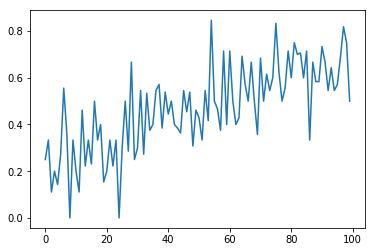

In [296]:
pl.plot(results[1],results[0])

In [284]:
#testing block __ graph generator
clique=[0,1,2,3,4]
Graph=graph_gen(8,5,clique)
print(Graph)

[array([[0., 1., 1., 1., 1., 0., 0., 0.],
       [1., 0., 1., 1., 1., 0., 0., 1.],
       [1., 1., 0., 1., 1., 1., 0., 1.],
       [1., 1., 1., 0., 1., 0., 0., 0.],
       [1., 1., 1., 1., 0., 1., 1., 1.],
       [0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 1., 1., 0., 1.],
       [0., 1., 1., 0., 1., 0., 1., 0.]]), array([1., 1., 1., 1., 1., 0., 0., 0.])]


In [249]:
#testing block __ algorithm
Wt=[1,1,1,1,0.2,0.2]
Wt=np.diag(Wt)
At=np.dot(Wt,np.dot(A,Wt))
print(At)
St=sample.sample(At,100,20,'False')
#St=sample.postselect(St,4,4)
St=np.array(St)
print(St)
tar=np.array([1,1,1,1,0,0])
num_tt=0
num_tot=0
for i in range(St.shape[0]):
    num_tot+=1
    st=St[i,:]
    if (st==tar).all():
        num_tt+=1
prob=num_tt/num_tot
print(num_tot/200)
print(prob)

[[0.   1.   1.   1.   0.   0.  ]
 [1.   0.   1.   1.   0.   0.  ]
 [1.   1.   0.   1.   0.   0.  ]
 [1.   1.   1.   0.   0.2  0.  ]
 [0.   0.   0.   0.2  0.   0.04]
 [0.   0.   0.   0.   0.04 0.  ]]
[[0 1 0 1 0 0]
 [1 1 0 0 0 0]
 [1 1 1 1 1 0]
 [1 1 1 1 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 0 0 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [1 1 1 1 0 0]
 [0 0 0 0 0 0]]
0.1
0.7
